In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [312]:
# loading users data
users = pd.read_csv('takehome_users.csv',encoding='ISO-8859-1')

In [313]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [314]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


'creation_time' & 'last_session_creation_time' columns need to be converted to datetime, 'last_session_creation_time' column has a lot of missing values; 'invited_by_user_id' need to be changed to integer data type.

In [315]:
# Changing data types
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

users.loc[users['invited_by_user_id'].isnull() == True,'invited_by_user_id'] = 0
users['invited_by_user_id'] = users['invited_by_user_id'].astype('int')

In [266]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  int64         
dtypes: datetime64[ns](2), int64(5), object(3)
memory usage: 937.6+ KB


In [316]:
users['creation_date'] = users['creation_time'].dt.date
users['last_session_date'] = users['last_session_creation_time'].dt.date

<Axes: xlabel='last_session_date'>

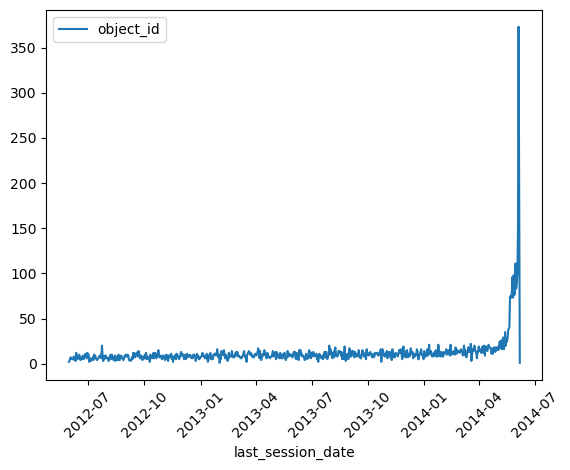

In [317]:
# investigating missing values for 'last_session_creation_time'
users.groupby('last_session_date').agg({'object_id':'count'}).sort_values(by='last_session_date').plot(rot=45)

In [318]:
missing_values = users[users['last_session_creation_time'].isnull()==True]

In [319]:
missing_values.groupby('creation_source').agg({'object_id':'count'}).reset_index().sort_values(by='object_id',ascending=False)

,creation_source,object_id
2,PERSONAL_PROJECTS,1347
1,ORG_INVITE,1066
0,GUEST_INVITE,575
3,SIGNUP,189


I don't see any pattern for 'last_session_creation_time' missing values. I may need to drop this column due to a high number fo missing values.

In [320]:
# Loading engagement data
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [321]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [322]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [323]:
engagement['date'] = engagement['time_stamp'].dt.date

In [324]:
def has_3_visits(group):
    group = group.set_index('date')
    rolling_sum = group['visited'].rolling(7).sum()
    return (rolling_sum >= 3).any()

In [325]:
grouped = engagement.groupby('user_id').apply(has_3_visits).reset_index()
grouped.rename(columns={0:'adopted'},inplace=True)
grouped.head()

/var/folders/5y/xktw_n857vb915jnv6mlqv6c0000gn/T/ipykernel_19009/947241178.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = engagement.groupby('user_id').apply(has_3_visits).reset_index()


,user_id,adopted
0,1,False
1,2,True
2,3,False
3,4,False
4,5,False


In [277]:
# Calculating recency and frequency
grouped2 = engagement.groupby('user_id').agg({'time_stamp':'max','visited':'sum'}).reset_index()
grouped2.rename(columns={'time_stamp':'last_visit_time','visited':'visit_counts'},inplace=True)
grouped2.head()

,user_id,last_visit_time,visit_counts
0,1,2014-04-22 03:53:30,1
1,2,2014-03-31 03:45:04,14
2,3,2013-03-19 23:14:52,1
3,4,2013-05-22 08:09:28,1
4,5,2013-01-22 10:14:20,1


In [278]:
# Merging two dataframes
data = users.merge(grouped, how='left',left_on='object_id',right_on='user_id')
data = data.merge(grouped2, how='left',left_on='object_id',right_on='user_id')

In [279]:
data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_date,last_session_date,user_id_x,adopted,user_id_y,last_visit_time,visit_counts
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,2014-04-22,2014-04-22,1.0,False,1.0,2014-04-22 03:53:30,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,2013-11-15,2014-03-31,2.0,True,2.0,2014-03-31 03:45:04,14.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,2013-03-19,2013-03-19,3.0,False,3.0,2013-03-19 23:14:52,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,2013-05-21,2013-05-22,4.0,False,4.0,2013-05-22 08:09:28,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,2013-01-17,2013-01-22,5.0,False,5.0,2013-01-22 10:14:20,1.0


In [280]:
data.drop(columns=['user_id_x','user_id_y','last_session_creation_time'],inplace=True)

In [281]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          12000 non-null  int64         
 9   creation_date               12000 non-null  object        
 10  last_session_date           8823 non-null   object        
 11  adopted                     8823 non-null   object    

In [282]:
# Filling in null values
data.loc[data['last_visit_time'].isnull()==True,'last_visit_time'] = data['creation_time']
data['last_session_date'] = data['last_visit_time'].dt.date
data.loc[data['visit_counts'].isnull()==True,'visit_counts'] = 0
data.loc[data['adopted'].isnull()==True,'adopted'] = False

In [283]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          12000 non-null  int64         
 9   creation_date               12000 non-null  object        
 10  last_session_date           12000 non-null  object        
 11  adopted                     12000 non-null  object    

In [285]:
current_date = max(data['last_session_date'])
current_date

datetime.date(2014, 6, 6)

In [339]:
data['recency'] = (pd.to_datetime(current_date) - pd.to_datetime(data['last_session_date'])).dt.days
data['creation_month'] = data['creation_time'].dt.month
data['creation_year'] = data['creation_time'].dt.year
data['dow'] = data['creation_time'].dt.weekday
data['is_invited'] = data['invited_by_user_id']!=0

In [340]:
data.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_date,last_session_date,adopted,last_visit_time,visit_counts,recency,creation_month,creation_year,dow,is_invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803,2014-04-22,2014-04-22,0,2014-04-22 03:53:30,1.0,45,4,2014,1,True
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316,2013-11-15,2014-03-31,1,2014-03-31 03:45:04,14.0,67,11,2013,4,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525,2013-03-19,2013-03-19,0,2013-03-19 23:14:52,1.0,444,3,2013,1,True
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151,2013-05-21,2013-05-22,0,2013-05-22 08:09:28,1.0,380,5,2013,1,True
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240,2013-01-17,2013-01-22,0,2013-01-22 10:14:20,1.0,500,1,2013,3,True


In [295]:
data['adopted'] = data['adopted'].astype('int')

In [296]:
data.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_date,last_session_date,adopted,last_visit_time,visit_counts,recency,creation_month,creation_year,dow
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803,2014-04-22,2014-04-22,0,2014-04-22 03:53:30,1.0,45,4,2014,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316,2013-11-15,2014-03-31,1,2014-03-31 03:45:04,14.0,67,11,2013,4
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525,2013-03-19,2013-03-19,0,2013-03-19 23:14:52,1.0,444,3,2013,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151,2013-05-21,2013-05-22,0,2013-05-22 08:09:28,1.0,380,5,2013,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240,2013-01-17,2013-01-22,0,2013-01-22 10:14:20,1.0,500,1,2013,3


In [297]:
data.adopted.value_counts(normalize=True)

adopted
0    0.864083
1    0.135917
Name: proportion, dtype: float64

### Exploring categorical features

In [192]:
#Writing a function for chi-squared test to check if difference between different categories is significant.
def chi_squared(var):
    
    # Create a contingency table
    contingency_table = pd.crosstab(data[var], data['adopted'])
    
    # Apply Chi-square test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
    
    # Combine observed and expected frequencies
    combined_table = pd.concat([contingency_table, expected_df], axis=1, keys=['Observed', 'Expected'])
    
    # Print the results
    print(f"The null hypothesis is: adoptions do not depend on {var}.")
    print(f"\nChi-square Statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of Freedom: {dof}")
    
    # Interpretation
    alpha = 0.05
    if p < alpha:
        print("\nThe result is significant, we reject the null hypothesis.")
    else:
        print("\nThe result is not significant, we fail to reject the null hypothesis.")

    print("\nCombined Table (Observed and Expected Frequencies):")
    print(combined_table)
    print('------------------------------------------------------')

In [341]:
cat_vars = ['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','creation_month','creation_year','dow','is_invited']

In [342]:
for var in cat_vars:
    chi_squared(var)

The null hypothesis is: adoptions do not depend on creation_source.

Chi-square Statistic: 89.17431033181632
P-value: 1.971909770612597e-18
Degrees of Freedom: 4

The result is significant, we reject the null hypothesis.

Combined Table (Observed and Expected Frequencies):
                   Observed          Expected            
adopted                   0    1            0           1
creation_source                                          
GUEST_INVITE           1800  363  1869.012250  293.987750
ORG_INVITE             3682  572  3675.810500  578.189500
PERSONAL_PROJECTS      1943  168  1824.079917  286.920083
SIGNUP                 1793  294  1803.341917  283.658083
SIGNUP_GOOGLE_AUTH     1151  234  1196.755417  188.244583
------------------------------------------------------
The null hypothesis is: adoptions do not depend on opted_in_to_mailing_list.

Chi-square Statistic: 0.5068716367388697
P-value: 0.4764962455374482
Degrees of Freedom: 1

The result is not significant, we fai

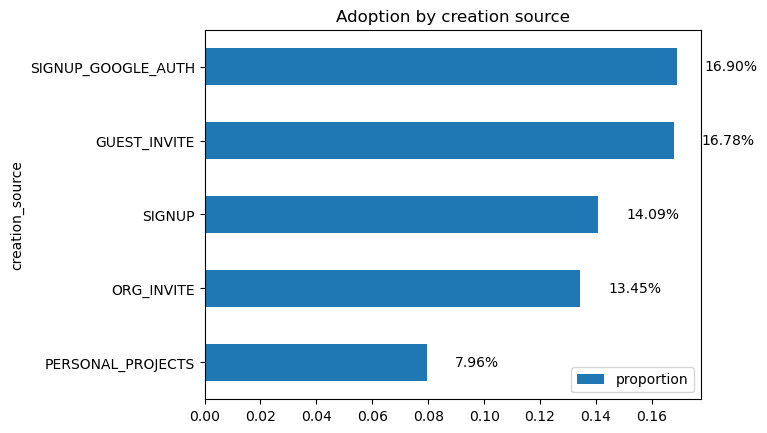

In [238]:
adoption_counts = data.groupby('creation_source')['adopted'].value_counts(normalize=True).reset_index()
adoption_counts = adoption_counts[adoption_counts['adopted']==True].drop(columns='adopted').set_index('creation_source').sort_values(by='proportion')

ax = adoption_counts.plot(kind='barh')

for i, value in enumerate(adoption_counts.iloc[:, 0]):
    plt.text(value + 0.01, i, f'{value:.2%}', va='center')
plt.title('Adoption by creation source')
plt.show()

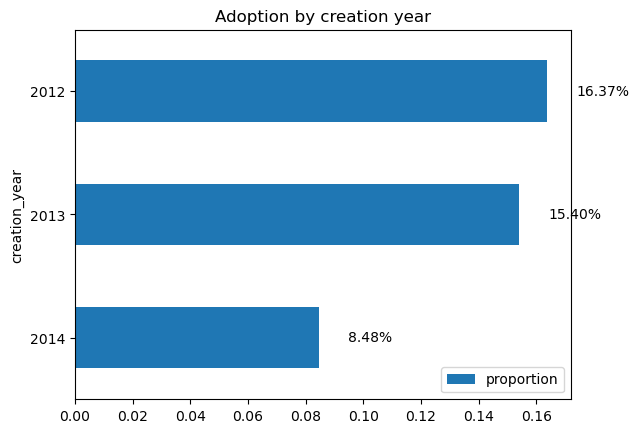

In [235]:
adoption_counts = data.groupby('creation_year')['adopted'].value_counts(normalize=True).reset_index()
adoption_counts = adoption_counts[adoption_counts['adopted']==True].drop(columns='adopted').set_index('creation_year').sort_values(by='proportion')
ax = adoption_counts.plot(kind='barh')

for i, value in enumerate(adoption_counts.iloc[:, 0]):
    plt.text(value + 0.01, i, f'{value:.2%}', va='center')
plt.title('Adoption by creation year')
plt.show()

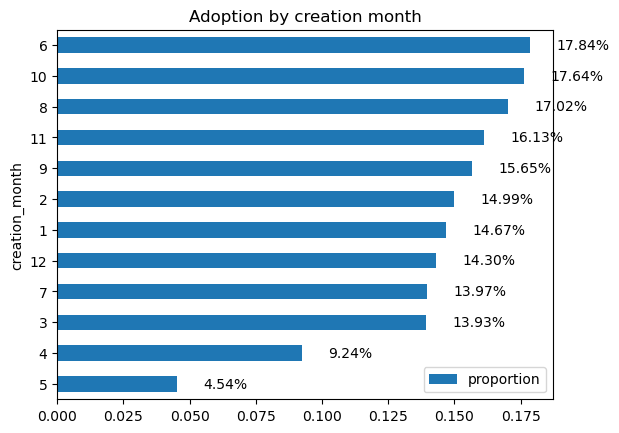

In [236]:
adoption_counts = data.groupby('creation_month')['adopted'].value_counts(normalize=True).reset_index()
adoption_counts = adoption_counts[adoption_counts['adopted']==True].drop(columns='adopted').set_index('creation_month').sort_values(by='proportion')
ax = adoption_counts.plot(kind='barh')

for i, value in enumerate(adoption_counts.iloc[:, 0]):
    plt.text(value + 0.01, i, f'{value:.2%}', va='center')
plt.title('Adoption by creation month')
plt.show()

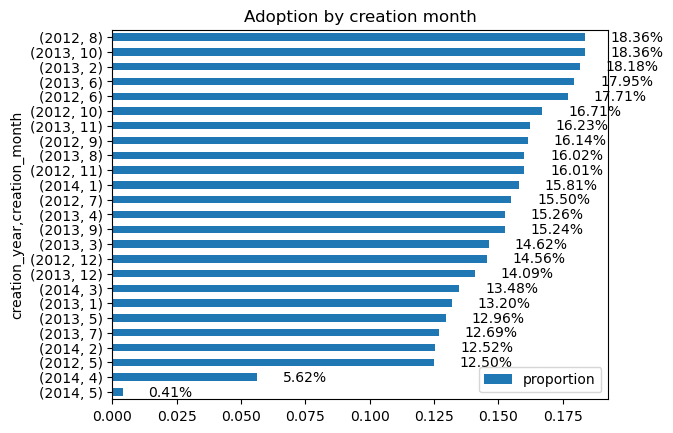

In [350]:
adoption_counts = data.groupby(['creation_year','creation_month'])['adopted'].value_counts(normalize=True).reset_index()
adoption_counts = adoption_counts[adoption_counts['adopted']==True].drop(columns='adopted').set_index(['creation_year','creation_month']).sort_values(by='proportion')
ax = adoption_counts.plot(kind='barh')

for i, value in enumerate(adoption_counts.iloc[:, 0]):
    plt.text(value + 0.01, i, f'{value:.2%}', va='center')
plt.title('Adoption by creation month')
plt.show()

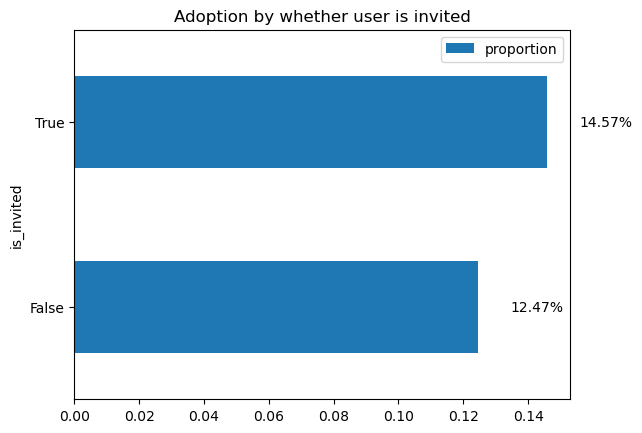

In [344]:
adoption_counts = data.groupby('is_invited')['adopted'].value_counts(normalize=True).reset_index()
adoption_counts = adoption_counts[adoption_counts['adopted']==True].drop(columns='adopted').set_index('is_invited').sort_values(by='proportion')

ax = adoption_counts.plot(kind='barh')

for i, value in enumerate(adoption_counts.iloc[:, 0]):
    plt.text(value + 0.01, i, f'{value:.2%}', va='center')
plt.title('Adoption by whether user is invited')
plt.show()

### Exploring numerical features

In [260]:
data['recency'] = pd.to_timedelta(data['recency']).dt.days
data['visit_counts'] = pd.to_numeric(data['visit_counts'], errors='coerce')
data['adopted'] = pd.to_numeric(data['adopted'], errors='coerce')

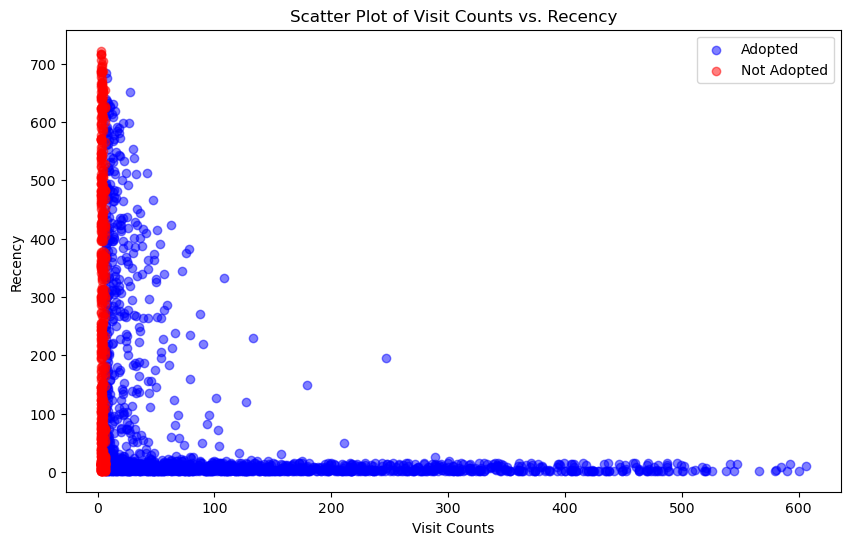

In [326]:
plt.figure(figsize=(10, 6))

plt.scatter(data[data['adopted'] == True]['visit_counts'],
            data[data['adopted'] == True]['recency'],
            color='blue',
            alpha=0.5,
            label='Adopted')

plt.scatter(data[(data['adopted'] == False)&(data['visit_counts']>2)]['visit_counts'], #excluding visitors with less than 3 visits, because by definition they can't be adopted users
            data[(data['adopted'] == False)&(data['visit_counts']>2)]['recency'],
            color='red',   
            alpha=0.5,
            label='Not Adopted')

plt.xlabel('Visit Counts')
plt.ylabel('Recency')
plt.title('Scatter Plot of Visit Counts vs. Recency')
plt.legend()
plt.show()

In [328]:
import statsmodels.api as sm

X = data.loc[data['visit_counts']>2,['recency', 'visit_counts']]
y = data.loc[data['visit_counts']>2,['adopted']]
X = sm.add_constant(X)  

logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                adopted   No. Observations:                 2248
Model:                          Logit   Df Residuals:                     2245
Method:                           MLE   Df Model:                            2
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                   1.000
Time:                        22:29:20   Log-Likelihood:            -1.8661e-06
converged:                      False   LL-Null:                       -1321.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -236.8665   9516.468     -0.025      0.980   -1.89e+04    1.84e+04
recency         -0.0002      3.507  -5.87e-05      1.000   

/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Even though not adopted users are the ones with low number of visits, the results of logistic regression show that not recency, nor frequency are significant enough to be a predictor for user adoption.

# Solution

### Identifying which factors predict future user adoption.
Out of 12000 users a bit less than 14% are adopted users. The most important features that predict future user adoption are:
* creation source: users invited for personal projects have the lowest adoption rate.
* creation date: users created in Apr-May 2014 have the lowest adoption rate.
* whether the user was invited by another user: users who were invited have higher adoption rate.

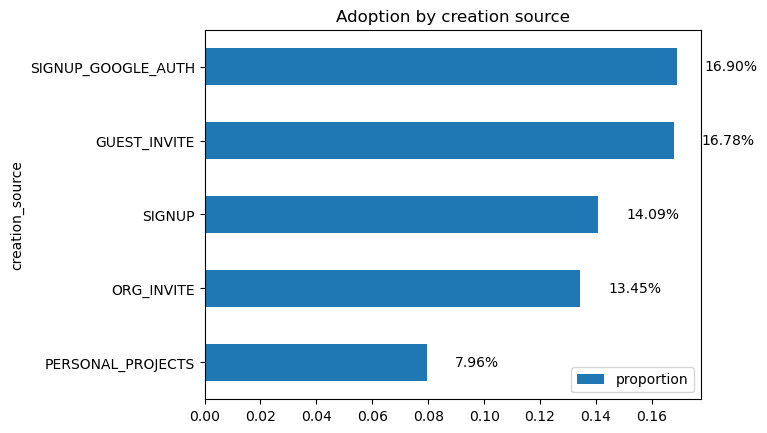

In [351]:
adoption_counts = data.groupby('creation_source')['adopted'].value_counts(normalize=True).reset_index()
adoption_counts = adoption_counts[adoption_counts['adopted']==True].drop(columns='adopted').set_index('creation_source').sort_values(by='proportion')

ax = adoption_counts.plot(kind='barh')

for i, value in enumerate(adoption_counts.iloc[:, 0]):
    plt.text(value + 0.01, i, f'{value:.2%}', va='center')
plt.title('Adoption by creation source')
plt.show()

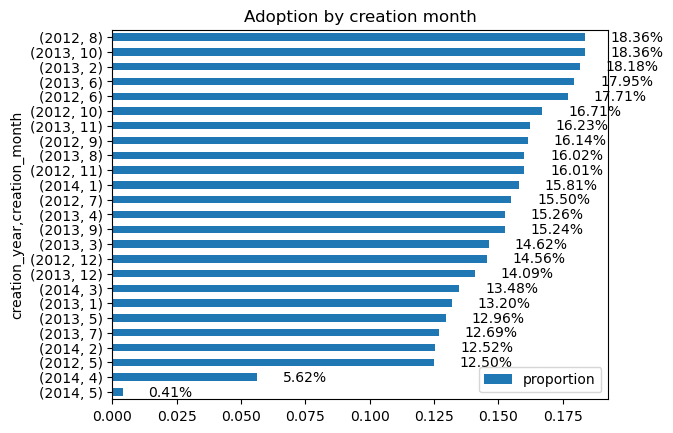

In [352]:
adoption_counts = data.groupby(['creation_year','creation_month'])['adopted'].value_counts(normalize=True).reset_index()
adoption_counts = adoption_counts[adoption_counts['adopted']==True].drop(columns='adopted').set_index(['creation_year','creation_month']).sort_values(by='proportion')
ax = adoption_counts.plot(kind='barh')

for i, value in enumerate(adoption_counts.iloc[:, 0]):
    plt.text(value + 0.01, i, f'{value:.2%}', va='center')
plt.title('Adoption by creation month')
plt.show()

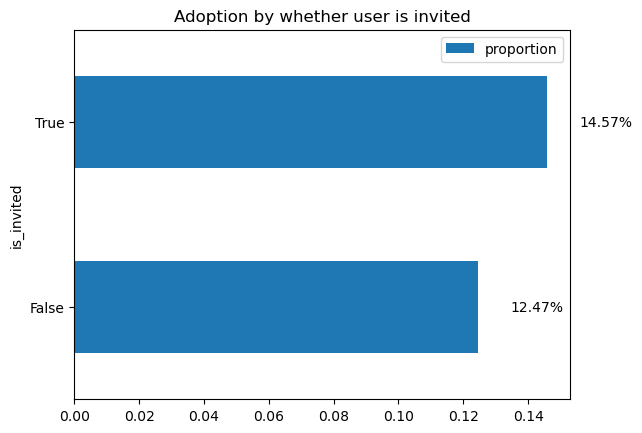

In [353]:
adoption_counts = data.groupby('is_invited')['adopted'].value_counts(normalize=True).reset_index()
adoption_counts = adoption_counts[adoption_counts['adopted']==True].drop(columns='adopted').set_index('is_invited').sort_values(by='proportion')

ax = adoption_counts.plot(kind='barh')

for i, value in enumerate(adoption_counts.iloc[:, 0]):
    plt.text(value + 0.01, i, f'{value:.2%}', va='center')
plt.title('Adoption by whether user is invited')
plt.show()